# 서울시 편의점 매출 결정요인 분석
## 06. 예측 모델

---

### 이 노트북의 목표
1. 매출 예측 모델 구축
2. 신규 입지의 예상 매출 산출
3. What-if 시나리오 분석

### 활용 시나리오
- "A동에 출점하면 매출이 얼마나 될까?"
- "유동인구가 20% 증가하면 매출은?"
- "발달상권 vs 골목상권, 예상 매출 차이는?"

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('./분석데이터.csv', encoding='utf-8-sig')
print(f"데이터: {len(df):,}건")

데이터: 6,097건


## 1. 예측 모델 구축

In [2]:
# 더미변수 생성
df['발달상권'] = (df['주요_상권유형'] == '발달상권').astype(int)
df['전통시장'] = (df['주요_상권유형'] == '전통시장').astype(int)
df['관광특구'] = (df['주요_상권유형'] == '관광특구').astype(int)
df['미분류'] = (df['주요_상권유형'] == '미분류').astype(int)

# 변수 설정
feature_cols = ['점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']
X = df[feature_cols]
y = df['당월_매출_금액']

# Train/Test 분할 (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터: {len(X_train):,}건")
print(f"테스트 데이터: {len(X_test):,}건")

학습 데이터: 4,877건
테스트 데이터: 1,220건


In [3]:
# 회귀모델 학습
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

print("[예측 모델 학습 완료]")
print(f"  R² (학습): {model.rsquared:.4f}")

[예측 모델 학습 완료]
  R² (학습): 0.6782


In [4]:
# 테스트 데이터로 예측 성능 평가
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("[테스트 데이터 예측 성능]")
print(f"  R² (테스트): {r2:.4f}")
print(f"  MAE: {mae/1e8:.2f}억원")
print(f"  RMSE: {rmse/1e8:.2f}억원")
print(f"  MAPE: {mape:.1f}%")
print(f"\n  → 평균적으로 실제 매출과 {mae/1e8:.2f}억원 오차")

[테스트 데이터 예측 성능]
  R² (테스트): 0.7174
  MAE: 12.67억원
  RMSE: 18.77억원
  MAPE: 544.9%

  → 평균적으로 실제 매출과 12.67억원 오차


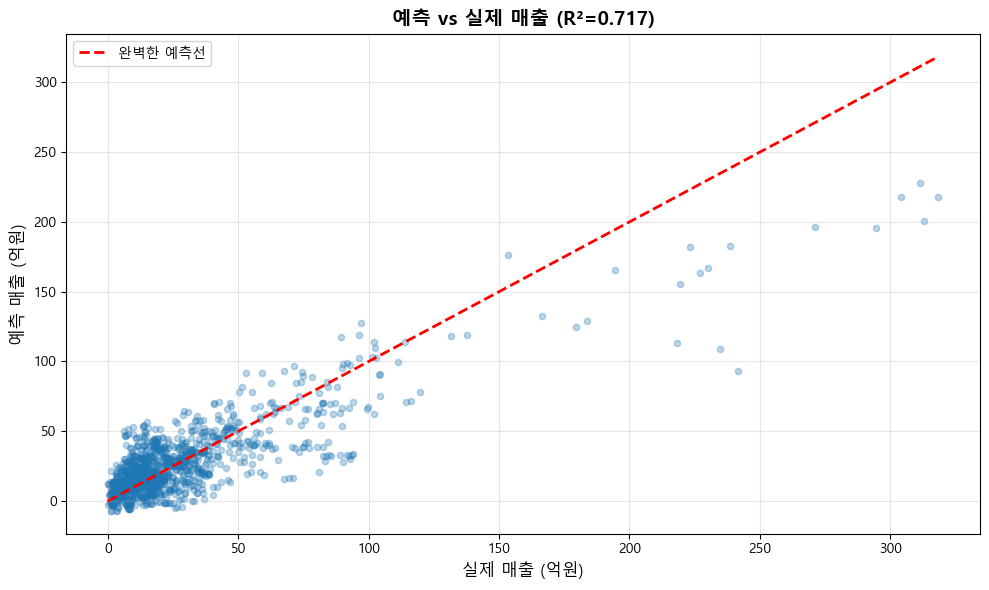

In [5]:
# 예측 vs 실제 시각화
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test/1e8, y_pred/1e8, alpha=0.3, s=20)
max_val = max(y_test.max(), y_pred.max()) / 1e8
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='완벽한 예측선')

ax.set_xlabel('실제 매출 (억원)', fontsize=12)
ax.set_ylabel('예측 매출 (억원)', fontsize=12)
ax.set_title(f'예측 vs 실제 매출 (R²={r2:.3f})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/08_예측vs실제.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. 매출 예측 함수

조건을 입력하면 예상 매출을 산출하는 함수

In [6]:
# 전체 데이터로 최종 모델 학습
X_all_const = sm.add_constant(X)
final_model = sm.OLS(y, X_all_const).fit()

def predict_sales(점포수, 유동인구, 상권유형='골목상권'):
    """
    입지 조건을 입력하면 예상 분기 매출(억원)을 반환
    
    Parameters:
    - 점포수: 해당 행정동의 편의점 점포수
    - 유동인구: 분기 총 유동인구 (명)
    - 상권유형: '골목상권', '발달상권', '전통시장', '관광특구', '미분류' 중 선택
    
    Returns:
    - 예상 매출 (억원)
    """
    # 더미변수 설정
    발달 = 1 if 상권유형 == '발달상권' else 0
    전통 = 1 if 상권유형 == '전통시장' else 0
    관광 = 1 if 상권유형 == '관광특구' else 0
    미분류 = 1 if 상권유형 == '미분류' else 0
    
    # 입력 데이터 구성
    input_data = pd.DataFrame({
        'const': [1],
        '점포_수': [점포수],
        '총_유동인구_수': [유동인구],
        '발달상권': [발달],
        '전통시장': [전통],
        '관광특구': [관광],
        '미분류': [미분류]
    })
    
    # 예측
    pred = final_model.predict(input_data)[0]
    return pred / 1e8  # 억원 단위

print("예측 함수 생성 완료: predict_sales(점포수, 유동인구, 상권유형)")

예측 함수 생성 완료: predict_sales(점포수, 유동인구, 상권유형)


In [7]:
# 예측 예시: 평균적인 조건
avg_stores = df['점포_수'].mean()
avg_pop = df['총_유동인구_수'].mean()

print("[예측 예시: 평균적인 조건]")
print(f"  입력: 점포수={avg_stores:.0f}개, 유동인구={avg_pop/1e6:.1f}백만명")
print()

for 상권 in ['골목상권', '발달상권', '전통시장', '관광특구']:
    예상매출 = predict_sales(avg_stores, avg_pop, 상권)
    print(f"  {상권}: 예상 매출 {예상매출:.2f}억원")

[예측 예시: 평균적인 조건]
  입력: 점포수=6개, 유동인구=5.6백만명

  골목상권: 예상 매출 25.29억원
  발달상권: 예상 매출 40.01억원
  전통시장: 예상 매출 37.23억원
  관광특구: 예상 매출 52.48억원


## 3. 신규 입지 매출 예측 시뮬레이터

In [8]:
print("=" * 65)
print("신규 입지 매출 예측 시뮬레이터")
print("=" * 65)

# 시나리오 1: 강남역 근처 (발달상권, 높은 유동인구)
print("\n[시나리오 1] 강남역 근처 발달상권")
print("  조건: 점포 15개, 유동인구 500만명, 발달상권")
pred1 = predict_sales(15, 5_000_000, '발달상권')
print(f"  → 예상 분기 매출: {pred1:.2f}억원")

# 시나리오 2: 주택가 (골목상권, 낮은 유동인구)
print("\n[시나리오 2] 주택가 골목상권")
print("  조건: 점포 3개, 유동인구 100만명, 골목상권")
pred2 = predict_sales(3, 1_000_000, '골목상권')
print(f"  → 예상 분기 매출: {pred2:.2f}억원")

# 시나리오 3: 명동 (관광특구)
print("\n[시나리오 3] 명동 관광특구")
print("  조건: 점포 20개, 유동인구 800만명, 관광특구")
pred3 = predict_sales(20, 8_000_000, '관광특구')
print(f"  → 예상 분기 매출: {pred3:.2f}억원")

# 시나리오 4: 전통시장 인근
print("\n[시나리오 4] 전통시장 인근")
print("  조건: 점포 5개, 유동인구 200만명, 전통시장")
pred4 = predict_sales(5, 2_000_000, '전통시장')
print(f"  → 예상 분기 매출: {pred4:.2f}억원")

신규 입지 매출 예측 시뮬레이터

[시나리오 1] 강남역 근처 발달상권
  조건: 점포 15개, 유동인구 500만명, 발달상권
  → 예상 분기 매출: 74.16억원

[시나리오 2] 주택가 골목상권
  조건: 점포 3개, 유동인구 100만명, 골목상권
  → 예상 분기 매출: 4.10억원

[시나리오 3] 명동 관광특구
  조건: 점포 20개, 유동인구 800만명, 관광특구
  → 예상 분기 매출: 112.17억원

[시나리오 4] 전통시장 인근
  조건: 점포 5개, 유동인구 200만명, 전통시장
  → 예상 분기 매출: 25.89억원


## 4. What-if 시나리오 분석

"유동인구가 변하면 매출은 얼마나 변할까?"

In [9]:
# 기준: 평균적인 골목상권
base_stores = df['점포_수'].mean()
base_pop = df['총_유동인구_수'].mean()
base_sales = predict_sales(base_stores, base_pop, '골목상권')

print("[What-if 분석: 유동인구 변화에 따른 매출 변화]")
print(f"기준: 점포 {base_stores:.0f}개, 유동인구 {base_pop/1e6:.1f}백만명, 골목상권")
print(f"기준 매출: {base_sales:.2f}억원")
print("-" * 50)

changes = [-30, -20, -10, 0, 10, 20, 30, 50]
results = []

for change in changes:
    new_pop = base_pop * (1 + change/100)
    new_sales = predict_sales(base_stores, new_pop, '골목상권')
    diff = new_sales - base_sales
    pct = (new_sales / base_sales - 1) * 100
    results.append({'변화율': change, '매출': new_sales, '차이': diff, '매출변화율': pct})
    print(f"  유동인구 {change:+3d}% → 매출 {new_sales:.2f}억원 ({diff:+.2f}억, {pct:+.1f}%)")

results_df = pd.DataFrame(results)

[What-if 분석: 유동인구 변화에 따른 매출 변화]
기준: 점포 6개, 유동인구 5.6백만명, 골목상권
기준 매출: 25.29억원
--------------------------------------------------
  유동인구 -30% → 매출 22.15억원 (-3.13억, -12.4%)
  유동인구 -20% → 매출 23.20억원 (-2.09억, -8.3%)
  유동인구 -10% → 매출 24.24억원 (-1.04억, -4.1%)
  유동인구  +0% → 매출 25.29억원 (+0.00억, +0.0%)
  유동인구 +10% → 매출 26.33억원 (+1.04억, +4.1%)
  유동인구 +20% → 매출 27.38억원 (+2.09억, +8.3%)
  유동인구 +30% → 매출 28.42억원 (+3.13억, +12.4%)
  유동인구 +50% → 매출 30.51억원 (+5.22억, +20.7%)


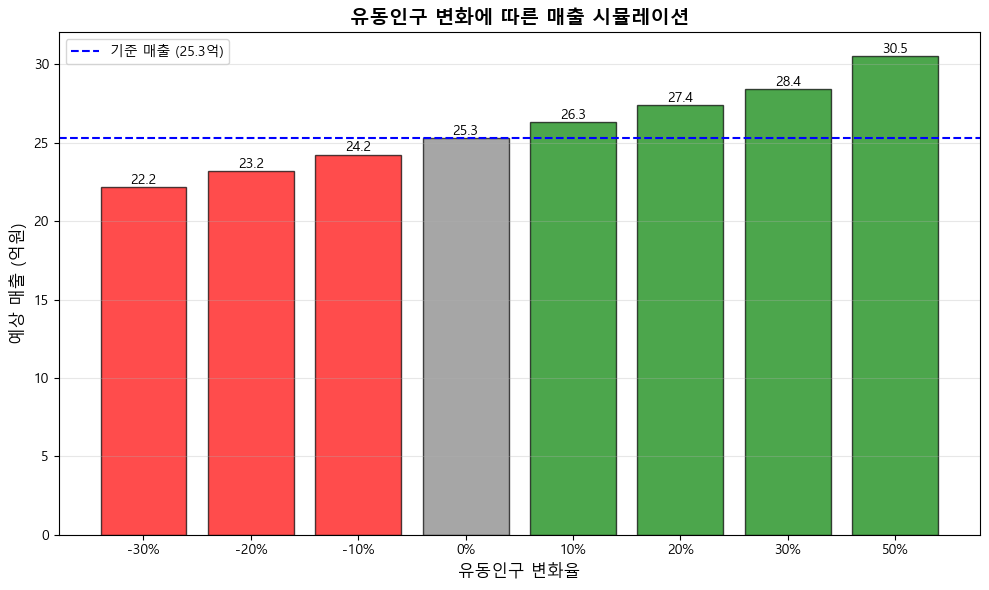

In [10]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if x < 0 else 'green' for x in results_df['변화율']]
colors[changes.index(0)] = 'gray'

bars = ax.bar(results_df['변화율'].astype(str) + '%', results_df['매출'], color=colors, alpha=0.7, edgecolor='black')

for bar, val in zip(bars, results_df['매출']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
            f'{val:.1f}', ha='center', fontsize=10)

ax.axhline(y=base_sales, color='blue', linestyle='--', label=f'기준 매출 ({base_sales:.1f}억)')
ax.set_xlabel('유동인구 변화율', fontsize=12)
ax.set_ylabel('예상 매출 (억원)', fontsize=12)
ax.set_title('유동인구 변화에 따른 매출 시뮬레이션', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/09_whatif_유동인구.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. 상권유형 전환 효과 분석

"같은 조건에서 상권유형만 바뀌면 매출이 얼마나 달라질까?"

In [11]:
print("[상권유형 전환 효과 분석]")
print(f"기준 조건: 점포 {base_stores:.0f}개, 유동인구 {base_pop/1e6:.1f}백만명")
print("-" * 50)

상권목록 = ['골목상권', '전통시장', '관광특구', '발달상권']
상권매출 = {}

for 상권 in 상권목록:
    매출 = predict_sales(base_stores, base_pop, 상권)
    상권매출[상권] = 매출

골목_매출 = 상권매출['골목상권']

for 상권 in 상권목록:
    매출 = 상권매출[상권]
    차이 = 매출 - 골목_매출
    print(f"  {상권}: {매출:.2f}억원 (골목상권 대비 {차이:+.2f}억원)")

[상권유형 전환 효과 분석]
기준 조건: 점포 6개, 유동인구 5.6백만명
--------------------------------------------------
  골목상권: 25.29억원 (골목상권 대비 +0.00억원)
  전통시장: 37.23억원 (골목상권 대비 +11.94억원)
  관광특구: 52.48억원 (골목상권 대비 +27.19억원)
  발달상권: 40.01억원 (골목상권 대비 +14.72억원)


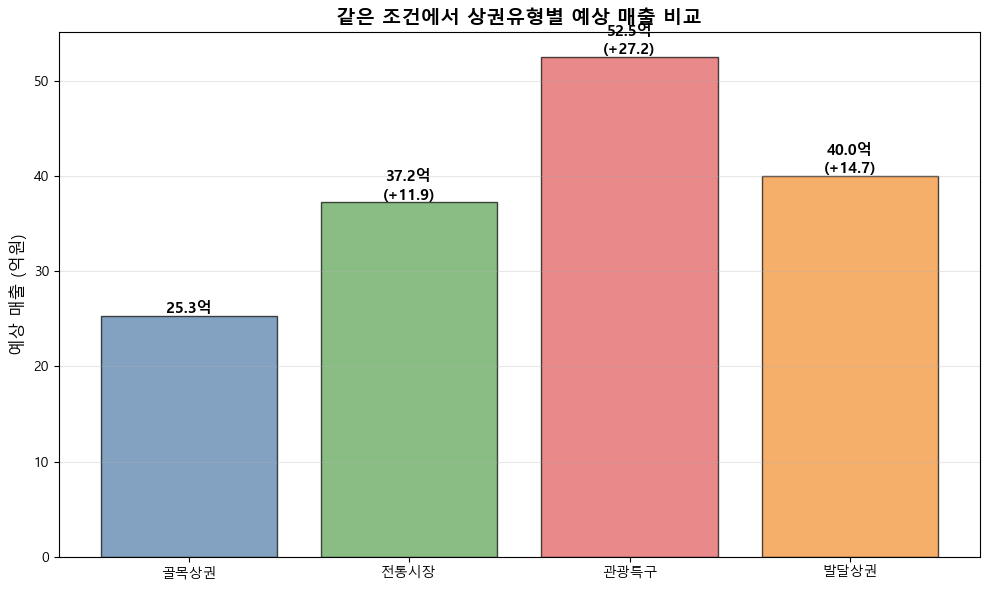

In [12]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'골목상권': '#4E79A7', '발달상권': '#F28E2B', '전통시장': '#59A14F', '관광특구': '#E15759'}
상권순서 = ['골목상권', '전통시장', '관광특구', '발달상권']

bars = ax.bar(상권순서, [상권매출[s] for s in 상권순서], 
              color=[colors[s] for s in 상권순서], alpha=0.7, edgecolor='black')

for bar, 상권 in zip(bars, 상권순서):
    val = 상권매출[상권]
    diff = val - 골목_매출
    label = f'{val:.1f}억' if 상권 == '골목상권' else f'{val:.1f}억\n({diff:+.1f})'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            label, ha='center', fontsize=11, fontweight='bold')

ax.set_ylabel('예상 매출 (억원)', fontsize=12)
ax.set_title('같은 조건에서 상권유형별 예상 매출 비교', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/10_상권유형_전환효과.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 예측 모델 요약

In [13]:
print("=" * 65)
print("예측 모델 요약")
print("=" * 65)

print(f"""
[모델 성능]
  R² = {r2:.4f} (테스트 데이터)
  MAE = {mae/1e8:.2f}억원 (평균 예측 오차)
  MAPE = {mape:.1f}% (평균 백분율 오차)

[예측 공식]
  매출 = {final_model.params['const']/1e8:.2f}억
       + {final_model.params['점포_수']/1e8:.2f}억 × 점포수
       + {final_model.params['총_유동인구_수']*1e6/1e8:.2f}억 × 유동인구(백만명)
       + 상권유형 효과

[상권유형 효과] (골목상권 대비)
  발달상권: {final_model.params['발달상권']/1e8:+.2f}억원
  관광특구: {final_model.params['관광특구']/1e8:+.2f}억원
  전통시장: {final_model.params['전통시장']/1e8:+.2f}억원
  미분류: {final_model.params['미분류']/1e8:+.2f}억원

[활용 방법]
  predict_sales(점포수, 유동인구, 상권유형) 함수 호출
  예: predict_sales(10, 3000000, '발달상권') → 예상 매출(억원)

다음: 07_인사이트.ipynb에서 저평가/고평가 지역 발굴
""")

예측 모델 요약

[모델 성능]
  R² = 0.7174 (테스트 데이터)
  MAE = 12.67억원 (평균 예측 오차)
  MAPE = 544.9% (평균 백분율 오차)

[예측 공식]
  매출 = -9.73억
       + 3.99억 × 점포수
       + 1.86억 × 유동인구(백만명)
       + 상권유형 효과

[상권유형 효과] (골목상권 대비)
  발달상권: +14.72억원
  관광특구: +27.19억원
  전통시장: +11.94억원
  미분류: +4.39억원

[활용 방법]
  predict_sales(점포수, 유동인구, 상권유형) 함수 호출
  예: predict_sales(10, 3000000, '발달상권') → 예상 매출(억원)

다음: 07_인사이트.ipynb에서 저평가/고평가 지역 발굴

